In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from glob import glob
import os
import re
import pyemma.msm as msm
import pyemma.coordinates as coor
import numpy as np
import my_network_plot as myplt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import operator
import pandas as pd
import mdtraj as md
import matplotlib.image as mpimg 


# Load the data

Below is the parameters cell for papermill parameterisation:

In [6]:
traj_num = 3
root_dir = 'msm_10ps'

The paths to the relevant objects

In [7]:
data_dir = root_dir+'/output_{}'.format(traj_num)
hmm_paths = glob(os.path.join(data_dir, '*_hmm_obj.pyemma'))
msm_paths = [os.path.join(data_dir, '{}_msm_obj.pyemma'.format(i)) for i in range(1000)]
dtraj_obj_paths = [os.path.join(data_dir, '{}_dtraj_obj.pyemma'.format(i)) for i in range(1000)]
dtraj_paths = [os.path.join(data_dir, '{}_dtraj.npy'.format(i)) for i in range(1000)]


### HMMs

This loads the HMM objects. 

In [8]:
hmms = [msm.MaximumLikelihoodHMSM().load(x) for x in hmm_paths]

/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


`hmm_idx` is a list of the time slices for which a HMM was converged. An idx of `2` indicates the slice `2 - 3 ns` has a HMM.    

In [9]:
hmm_idx = [int(re.search('^[0-9]+', os.path.basename(x)).group(0)) for x in hmm_paths]
hmm_idx[:10]

[2, 994, 981, 882, 27, 127, 132, 784, 868, 208]

`no_hmm_idx` is a list of the time slices for which there is no HMM. 

In [10]:
no_hmm_idx = list(set(np.arange(1000)) - set(hmm_idx))

`hmm_dict` is a dictionary of the HMMs. 
* key : the index of the time slice
* value: the HMM object

In [11]:
hmm_dict = dict(zip(hmm_idx, hmms))
total_hmms = len(hmm_dict)

### MSMs


Now load the MSMs. There's one for every timeslice so we don't need to label and put them in a dictionary.   

In [12]:
msms = [msm.MaximumLikelihoodMSM().load(x) for x in msm_paths]

This is the conversion between lag in frames (which the MSM object keeps) and the time in ps. 

In [13]:
lag = msms[0].lagtime
dt = np.round(10/lag, 2)
dt 

0.10000000000000001

### Cluster centers 

In [14]:
import pyemma.coordinates
from pyemma.coordinates.clustering import KmeansClustering

In [15]:
ccs = [KmeansClustering(n_clusters=1).load(x).clustercenters for x in dtraj_obj_paths]

### Discrete trajectories

In [16]:
dtrajs = [np.load(x) for x in dtraj_paths]

In [17]:
ccs_all = np.concatenate(ccs, axis=0)
ccs_all.shape

(100000, 3)

# Identifying interesting time slices


We only want to keep those chunks for which the timescales and corresponding HMM meet certain criteria. 

1. The HMM can't contain absorbing states. 
2. The MSM timescales are all longer than the MSM lag time (so are not spurious). 


## Get MSM timescales
First let's get the timescales from the MSMs.  This is irrespective of whether they have clear separation or not. We'll keep the first three for clarity. 

In [18]:
msm_timescales = np.concatenate([mm.timescales()[np.newaxis, :3] for mm in msms], axis=0)
msm_timescales.shape

(1000, 3)

## Remove slices with absorbing states

If there is a `1` on the diagonal of the transition matrix there is an absorbing state. Remove these timeslices. 

In [19]:
hmm_dict = {k : v for k, v in hmm_dict.items() if not np.any(np.diag(v.transition_matrix)==1)}

n_hmms_no_absorbing = len(hmm_dict)
n_hmms_no_absorbing

284

## Remove slices with zero weight states

Some HMMs have states with stationary distribution of zero. Let's remove these. 

In [20]:
hmm_dict = {k : v for k, v in hmm_dict.items() if not np.any(v.stationary_distribution < 1e-8)}

n_hmms_no_zero_weight = len(hmm_dict)
n_hmms_no_zero_weight

276

## Calculate number of non-spurious timescales

Now calculate the number of states if they're non-spurious i.e. timescales greater than the lag time. 

In [21]:
n_states = {k: v.nstates for k, v in hmm_dict.items() if msm_timescales[k,v.nstates-2] >= 2*lag}
hmm_dict = {k: hmm_dict[k] for k, v in n_states.items()}
n_hmm_non_spurious = len(hmm_dict)
n_hmm_non_spurious

164

## Map the number of states to the timeslices

This is a list of lists which gives the chunks which have 2 (and 3, and 4) states. Note, this is different to list in timescales.ipynb


In [22]:
idx_by_n_states = [[k for k, v in n_states.items() if v==i] for i in range(2,5)]
idx_by_n_states = [x for x in idx_by_n_states if len(x) > 0]
idx_by_n_states = [no_hmm_idx] + idx_by_n_states
len(idx_by_n_states)

4

# MSM plot 

## Randomly select timeslices with 2, 3, and 4 states

In [28]:
np.random.seed(42)
chunks = []
max_n_states = len(idx_by_n_states)
chunks = [(i+1, np.random.choice(idx_by_n_states[i])) for i in range(1,max_n_states)]
chunks = sorted(chunks, key=operator.itemgetter(1))
chunks

[(2, 255), (4, 821), (3, 932)]

## Save time slices with state information


In [29]:
for chunk in chunks:
    idx = chunk[1]
    xyz = ccs[idx]
    n = xyz.shape[0]
    mod = hmm_dict[idx]
    res_idx_ordered = np.argsort(mod.metastable_assignments)
    res_seq = mod.metastable_assignments[res_idx_ordered]+1
    #serial name element  resSeq resName  chainID
    top = pd.DataFrame({'serial': np.arange(n), 
                       'name': np.repeat(['X'], n), 
                       'element': np.repeat(['H'], n), 
                       'resSeq': res_seq, 
                       'resName': res_seq.astype(str), 
                       'chainID': np.repeat(['A'], n)})
    traj = md.Trajectory(np.expand_dims(xyz[res_idx_ordered, :], 0), topology = md.Topology().from_dataframe(top))
    traj.save_pdb('slice_{}_with_states.pdb'.format(idx))

## Save all time slices

In [83]:
n = ccs_all.shape[0]
top = pd.DataFrame({'serial': np.arange(n), 
                   'name': np.repeat(['X'], n), 
                   'element': np.repeat(['H'], n), 
                   'resSeq': np.repeat([1], n), 
                   'resName': np.repeat([1], n).astype(str), 
                   'chainID': np.repeat(['A'], n)})
traj = md.Trajectory(np.expand_dims(ccs_all, 0), topology = md.Topology().from_dataframe(top))

length = np.max(ccs_all.reshape(-1,3).max(axis=0)- ccs_all.reshape(-1,3).min(axis=0))



2.440377

In [95]:
traj.unitcell_angles = np.tile(90,(1, 3))
traj.unitcell_lengths = np.tile(length,(1, 3))
traj.save_pdb('all_slices.pdb'.format(idx))


## Colors for VMD

In [27]:
np.set_printoptions(precision=2)
N = 3
cmap_use = 'viridis_r'
cmap = matplotlib.cm.get_cmap(cmap_use,N)
cols = np.array([list(cmap(n)) for n in range(N)])
cols

array([[ 0.99,  0.91,  0.14,  1.  ],
       [ 0.13,  0.56,  0.55,  1.  ],
       [ 0.27,  0.  ,  0.33,  1.  ]])

In [27]:
def remove_spines(ax):
    _ = [x.set_visible(False) for x in ax.spines.values()]
    return ax

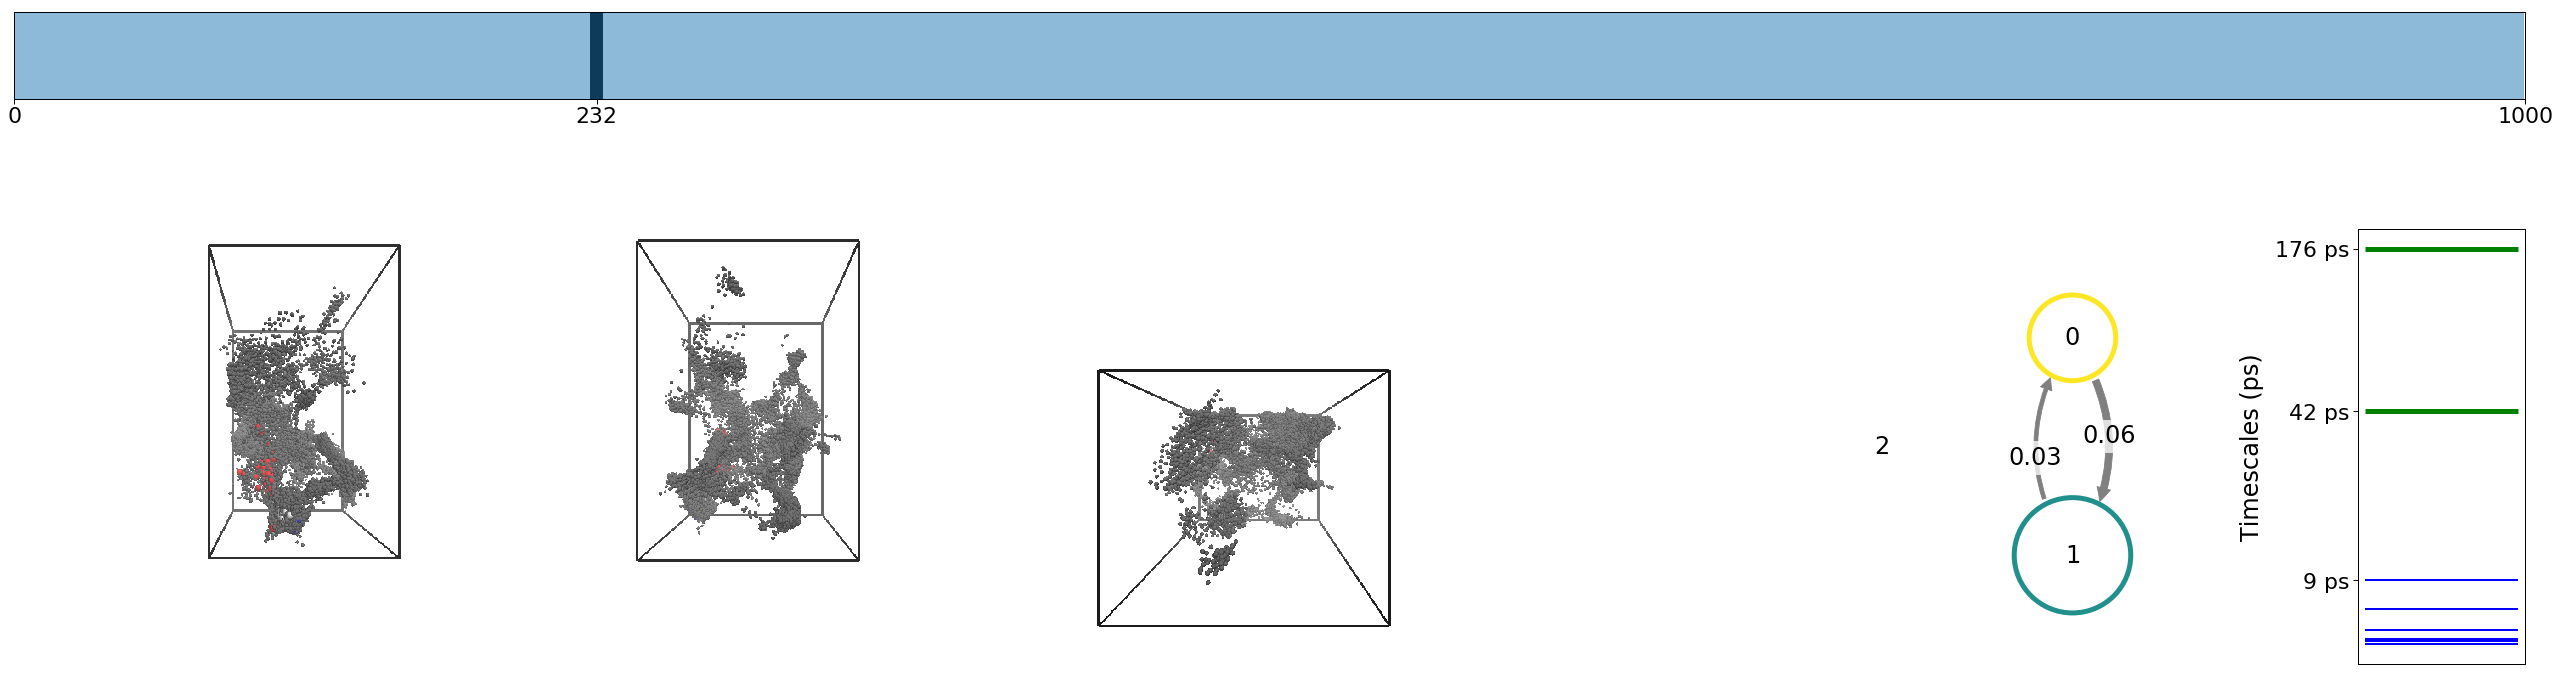

In [49]:
TRAJ_LEN=1000
with sns.plotting_context('paper', font_scale=2.5):

    # Get the relevant data
    idx = chunks[1][1]
    hmm = hmms_dict[idx]
    N = hmm.nstates
    pi = hmm.pi
    
    
    # Set up figure and axes
    scale=3
    fig = plt.figure(figsize=(scale*15, scale*4))
    gs = fig.add_gridspec(2, 5,
                          width_ratios=[3,3,3, 5,1], wspace=0, 
                          height_ratios=[1,5], hspace=0.5)
    
    ax_title = fig.add_subplot(gs[0,:])
    axes = [fig.add_subplot(gs[1,i]) for i in range(3)]
    ax2 = fig.add_subplot(gs[1,3])
    ax3 = fig.add_subplot(gs[1,4])

    # Colors 
    cmap_use = 'viridis_r'
    cmap = matplotlib.cm.get_cmap(cmap_use,N)
    cols = [cmap(n) for n in range(N)]

    # Title
    ax_title.tick_params(which='both', labelbottom=True,labelleft=False,labeltop=False,labelright=False,
                      bottom=True, left=False, top=False, right=False)
    ax_title.bar(np.array([idx]), np.array([1]), width=5, zorder=1, color='k')
    ax_title.bar(np.arange(TRAJ_LEN), np.ones(TRAJ_LEN), width=1, zorder=1, alpha=0.5)
    ax_title.set_ylim(0,1)
    ax_title.set_xlim(0, TRAJ_LEN)
    _ = [x.set_visible(True) for x in ax_title.spines.values()]
    ax_title.xaxis.set_major_locator(ticker.FixedLocator(locs=[0, idx, TRAJ_LEN]))
    
    # Import cluster images
    suffixes = ['xy', 'yz', 'zx']
    filenames = ['{0}_cluster-{1}.tga'.format(idx, x) for x in suffixes]
    
    for i, ax in enumerate(axes):
        img = mpimg.imread(filenames[i])
        ax.imshow(img)
        ax.tick_params(which='both', labelbottom=False,labelleft=False,labeltop=False,labelright=False,
                      bottom=False, left=False, top=False, right=False)
        
        ax = remove_spines(ax)
        
    # Network
    r = 0.8
    x = np.array([r * np.cos(2*np.pi*n/N + np.pi/6) for n in range(N)])
    y = np.array([r * np.sin(2*np.pi*n/N + np.pi/6) for n in range(N)])
    pos = np.concatenate((y[:,np.newaxis], x[:, np.newaxis]), axis=1)
    _, _ = myplt.plot_markov_model(hmm.transition_matrix, ax=ax2, 
                                  arrow_curvature=3, state_colors=cols,
                                  arrow_label_format = '%2.2f',pos=pos,
                                  figpadding=0.5, arrow_scale=0.5, state_scale=2)

    # Timescale plots
    mm = msms[idx]
    t_max = 10
    ts = mm.timescales()[:t_max]*dt

    # Slow:
    ax3.hlines(ts[0], 0, 1, lw=5, color='g', label='Slow')
    for i in range(1,N-1): 
        ax3.hlines(ts[i], 0, 1, lw=5, color='g')
    # Fast
    ax3.hlines(ts[N-1], 0, 1, lw=2, color='b', label='Fast')
    for i in range(N-1,t_max): ax3.hlines(ts[i], 0, 1, lw=2, color='b')
    
    # Labels
    ax3.set_yscale('log')
    ax3.set_ylabel('Timescales (ps)')
    
    # Tick marks for timescale plots
    locator = matplotlib.ticker.FixedLocator(locs=ts[:N], nbins=N)
    formatter = matplotlib.ticker.StrMethodFormatter('{x:4.0f} ps')
    ax3.yaxis.set_major_formatter(formatter)
    ax3.yaxis.set_major_locator(locator)
    ax3.tick_params(which='minor', labelleft=False, left=False)
    ax3.tick_params(which='major', labelbottom = False, bottom=False)
    
    plt.savefig('traj-{0}_idx-{1}.pdf'.format(traj_num, idx))
#     plt.tight_layout()


In [50]:
pi

array([0.35574857, 0.64425143, 0.        ])